In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from skimage.data import shepp_logan_phantom
from skimage.transform import rescale

image = shepp_logan_phantom()
image = rescale(image, scale=.4, mode='reflect', channel_axis=None)
print(f'Image shape: {image.shape}')

Image shape: (160, 160)


In [4]:
angles = np.arange(0, 180, 1)

Sinogram shape: (160, 180)


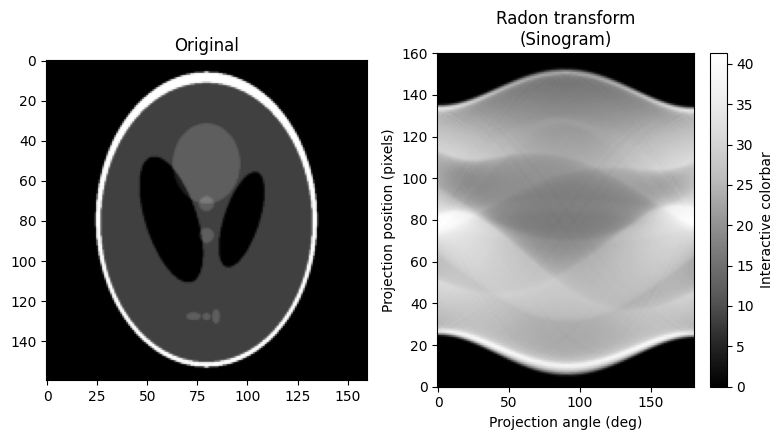

In [5]:
from radon import radon

sino = radon(image, angles=angles, method='bilinear', mp = True)
print(f'Sinogram shape: {sino.shape}')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)
dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sino.shape[0]
ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
im =ax2.imshow(
    sino,
    cmap=plt.cm.Greys_r,
    extent=(-dx, 180.0 + dx, -dy, sino.shape[0] + dy),
    aspect='auto',
)
fig.colorbar(im, label='Interactive colorbar')

fig.tight_layout()
plt.show()

FBP rms reconstruction error: 0.0961


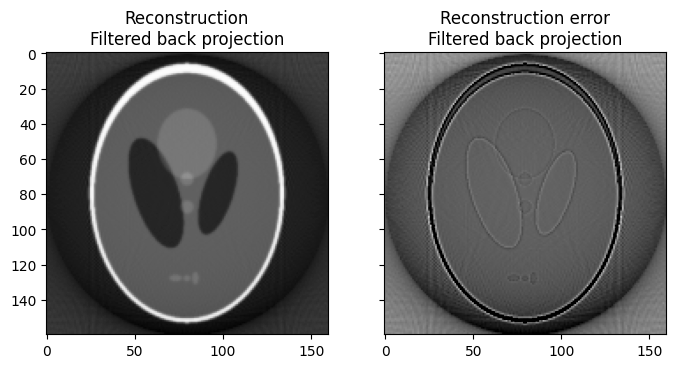

In [6]:
from inverse_radon import iradon

reconstruction_fbp = iradon(sino, angles)
error = reconstruction_fbp - image
print(f'FBP rms reconstruction error: {np.sqrt(np.mean(error ** 2)):.3g}')

imkwargs = dict(vmin=-0.2, vmax=0.2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6), sharex=True, sharey=True)
ax1.set_title("Reconstruction\nFiltered back projection")
im = ax1.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
ax2.set_title("Reconstruction error\nFiltered back projection")
ax2.imshow(reconstruction_fbp - image, cmap=plt.cm.Greys_r, **imkwargs)
# fig.colorbar(im, label='Interactive colorbar')
plt.show()

# Control Comparison to SkImage

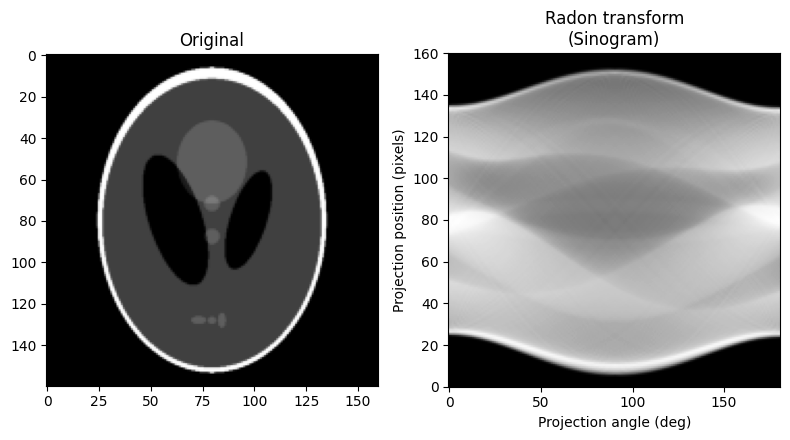

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale

image = shepp_logan_phantom()
image = rescale(image, scale=0.4, mode='reflect', channel_axis=None)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

sinogram = radon(image, theta=angles)
dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(
    sinogram,
    cmap=plt.cm.Greys_r,
    extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
    aspect='auto',
)

fig.tight_layout()
plt.show()

FBP rms reconstruction error: 0.0282


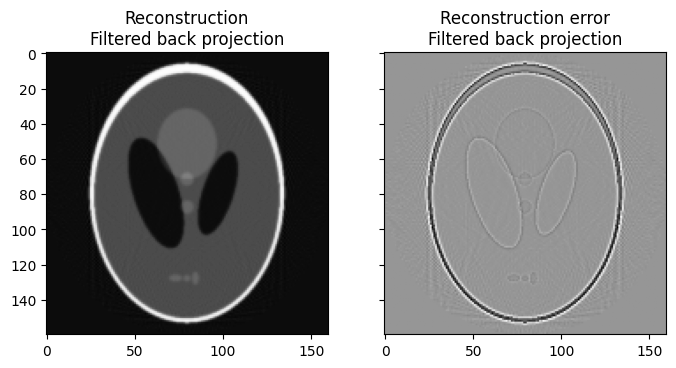

In [8]:
from skimage.transform import iradon

reconstruction_fbp = iradon(sinogram, theta=angles, filter_name='ramp')
error = reconstruction_fbp - image
print(f'FBP rms reconstruction error: {np.sqrt(np.mean(error ** 2)):.3g}')

imkwargs = dict(vmin=-0.2, vmax=0.2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5), sharex=True, sharey=True)
ax1.set_title("Reconstruction\nFiltered back projection")
ax1.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
ax2.set_title("Reconstruction error\nFiltered back projection")
ax2.imshow(reconstruction_fbp - image, cmap=plt.cm.Greys_r, **imkwargs)
plt.show()

In [9]:
from utils import load_vector
data = load_vector('ATTPT02010CTReqZsinogram.dat')